## Load Data

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
train = pd.read_csv('../../dataset/train.csv')
test = pd.read_csv('../../dataset/test.csv')

## Data Cleansing

### Handle Missing Values

In [152]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Dapat dilihat bahwa tidak ada missing value dalam dataset

### Handle Duplicacted Data

In [153]:
train.duplicated(subset=['id']).sum()

0

In [154]:
train.drop('id', axis=1 ,inplace=True)

Dapat dilihat bahwa pada kolom 'id' tidak ada data duplikat yang ditemukan, sehingga dapat disimpulkan bahwa tidak ada data duplikat dalam dataset ini.

### Handlle Outliers

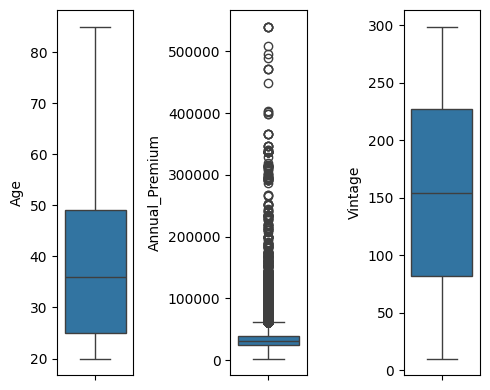

In [155]:
nums = ["Age","Annual_Premium","Vintage"]

plt.figure(figsize=(5, 4))
for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=train[nums[i]], orient='v')
    plt.tight_layout()

Dapat dilihat bahwa annual premium memiliki outliers yang cukup banyak

In [156]:
def remove_outliers_iqr(dataframe, column_name):
    # Calculate the IQR
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to exclude outliers
    filtered_dataframe = dataframe[(dataframe[column_name] >= lower_bound) & (dataframe[column_name] <= upper_bound)]

    # Display information about the removed outliers
    outliers_removed = dataframe.shape[0] - filtered_dataframe.shape[0]
    print(f"Number of outliers removed in '{column_name}': {outliers_removed}")

    return filtered_dataframe

Karena visualisasi outlier dilakukan menggunakan boxplot, maka penghapusan outlier akan menggunakan metode IQR 

Number of outliers removed in 'Annual_Premium': 10320


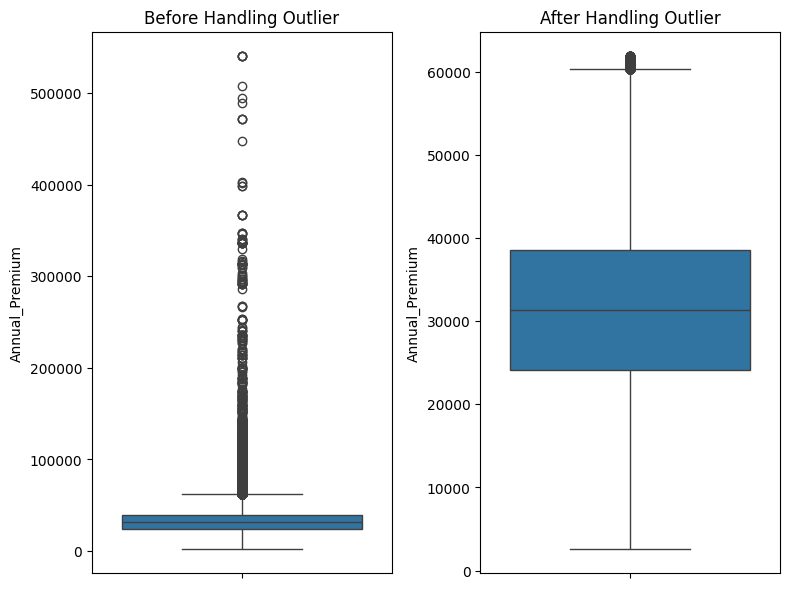

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.boxplot(train['Annual_Premium'], ax=axes[0])
axes[0].set_title('Before Handling Outlier')

# Using IQR to handle outlier
train = remove_outliers_iqr(train, 'Annual_Premium')

sns.boxplot(train['Annual_Premium'], ax=axes[1])
axes[1].set_title('After Handling Outlier')

plt.tight_layout()
plt.show()

Dapat dilihat outlier sudah terhapus sebanyak 1320, dapat dilihat pada boxplot bahwa range dari data annual premium sudah masuk ke dalam range boxplot yang lama

### Feature Transformation

In [158]:
nums = ['Age', 'Annual_Premium', 'Vintage']

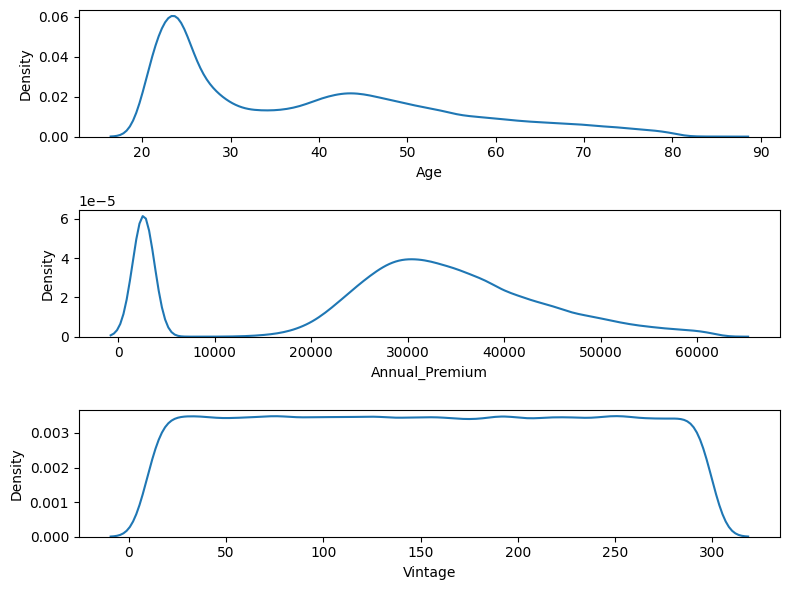

In [159]:
plt.figure(figsize=(8, 6))
for i in range(0, len(nums)):
    plt.subplot(len(nums), 1, i+1)
    sns.kdeplot(train[nums[i]])
    plt.tight_layout()

Dapat dilihat bahwa persebaran fitur numerik pada daset ini belum normal. Selanjutnya, pada annual_premium dapat dilihat bahwa range yang dimiliki sangat berbeda jauh dari kedua fitur numerik lainnya. Maka dari itu, Transformasi fitur akan menggunakan Log Tranformation untuk membuat distribusi fitur lebih simetrik.

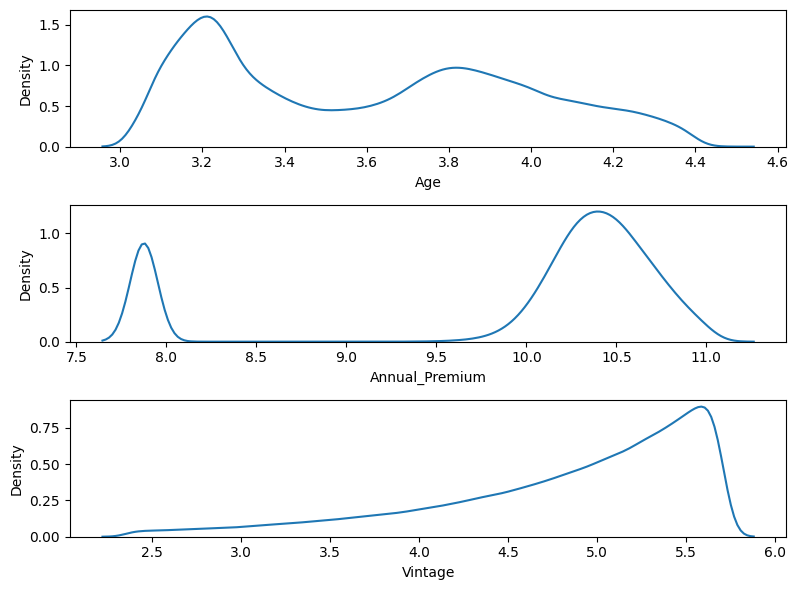

In [160]:
plt.figure(figsize=(8, 6))
for i in range(0, len(nums)):
    # Do Log Transformation
    train[nums[i]] = np.log1p(train[nums[i]])
    test[nums[i]] = np.log1p(train[nums[i]])

    # Plot the result
    plt.subplot(len(nums), 1, i+1)
    sns.kdeplot(train[nums[i]])
    plt.tight_layout()

### Feature Encodinng

Feature encoding akan dilakukan terhadap variable kategorikal supaya menjadi variable numerik dengan label encoding

In [161]:
cats = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [162]:
train[cats].describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,370789,370789,370789
unique,2,3,2
top,Male,1-2 Year,Yes
freq,200319,194212,186561


Di bawah ini adalah label encoding untuk fitur kategorikal yang ada 

In [163]:
mapping_gender = {
     'Male' : 0,
     'Female' : 1
}

mapping_vehicle_age = {
     '< 1 Year' : 0,
     '1-2 Year' : 1,
     '> 2 Years' : 2
}

mapping_vehicle_damage = {
     'No' : 0,
     'Yes' : 1
}

Label encoding akan dilakukan pada train dan test agar fitur yang dimasukkan ke dalam model machine learning dapat direpresentasikan sebagai nilai numerik. 

In [164]:
train['Gender'] = train['Gender'].map(mapping_gender)
test['Gender'] = test['Gender'].map(mapping_gender)

In [165]:
train['Vehicle_Age'] = train['Vehicle_Age'].map(mapping_vehicle_age)
test['Vehicle_Age'] = test['Vehicle_Age'].map(mapping_vehicle_age)

In [166]:
train['Vehicle_Damage'] = train['Vehicle_Damage'].map(mapping_vehicle_damage)
test['Vehicle_Damage'] = test['Vehicle_Damage'].map(mapping_vehicle_damage)

### Handle Class Imbalance

In [167]:
train.Response.value_counts()

Response
0    325634
1     45155
Name: count, dtype: int64

Dapat dilihat, hasil response menunjukkan bahwa terjadi class imbalance antara response 0 dan 1.

In [168]:
X_train = train.drop('Response', axis=1)
y_train = train['Response']

Pada penelitian ini, kami akan menggunakan undersampling karena ingin menangani ketidakseimbangan kelas dalam dataset. Undersampling membantu mengurangi jumlah instansi dari kelas mayoritas sehingga setiap kelas memiliki jumlah observasi yang lebih seimbang. 

Kami melakukan undersampling karena banyak data kelas minoritas masih cukup banyak dan kami beropini bahwa menggunakan data real lebih baik daripada membuat data sintetis menggunakan oversampling

In [169]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [170]:
train = pd.concat([X_train, y_train], axis=1)
train.Response.value_counts()

Response
0    45155
1    45155
Name: count, dtype: int64

Dapat dilihat, sekarang class response menjadi seimbang

In [171]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
255531,1,3.091042,1,46.0,1,0,0,10.325384,152.0,5.049856,0
27423,1,3.258097,1,46.0,1,0,0,10.485871,152.0,5.602119,0
253915,0,3.970292,1,46.0,1,1,1,10.198468,26.0,4.663439,0
167018,1,3.367296,1,18.0,1,0,0,10.979087,152.0,3.332205,0
26965,1,3.806662,1,11.0,0,1,1,10.411810,122.0,5.313206,0


## Feature Engineering

### Feature Extraction

Feature extraction akan dilakukan dengan membuat feature baru dari feature yang sudah ada. Feature extraction ini akan dilakukan pada data train dan test agar kedua data tersebut memiliki dimensi yang sama ketika dimasukkan ke dalam model.

#### Annual Premium Bin

In [172]:
# Binning the 'Annual_Premium' column
train['Annual_Premium_Binned'], bin_edges = pd.cut(train['Annual_Premium'], bins=3, labels=False, retbins=True)
print("Bin Edges:", bin_edges)

Bin Edges: [ 7.87196142  8.92774106  9.98036284 11.03298462]


In [173]:
# Applying the bin edges to the 'Annual_Premium' column in the test data
test['Annual_Premium_Binned'] = pd.cut(test['Annual_Premium'], bins=bin_edges, labels=False)

#### Vintage Bin

In [174]:
# Binning the 'Vintage' column
train['Vintage_Binned'], bin_edges = pd.qcut(train['Vintage'], q=6, labels=False, retbins=True)
print("Bin Edges:", bin_edges)

Bin Edges: [2.39789527 4.06044301 4.66343909 5.0369526  5.31320598 5.52545294
 5.70378247]


In [178]:
# Applying the bin edges to the 'Annual_Premium' column in the test data
test['Vintage_Binned'] = pd.cut(test['Vintage'], bins=bin_edges, labels=False)

#### Age Bin

In [179]:
train['Age_Bin'], bin_edges = pd.qcut(train['Age'], q=5, labels=False, retbins=True)

print("Bin Edges:", bin_edges)

Bin Edges: [3.04452244 3.25809654 3.61091791 3.80666249 3.98898405 4.4308168 ]


In [181]:
test['Age_Bin'] = pd.cut(test['Age'], bins=bin_edges, labels=False)

#### Premium to Age Ratio

In [182]:
train['Premium_to_Age_Ratio'] = train['Annual_Premium'] / train['Age']

In [183]:
test['Premium_to_Age_Ratio'] = test['Annual_Premium'] / test['Age']

#### Age and Vehicle Age

In [184]:
train['Age_Vehicle_Age_Interaction'] = train['Age_Bin'] * train['Vehicle_Age']

In [185]:
test['Age_Vehicle_Age_Interaction'] = test['Age_Bin'] * test['Vehicle_Age']

#### Vehicle Damage dan Age

In [186]:
train['Vehicle_Damage_Age_Interaction'] = train['Age_Bin'] * train['Vehicle_Damage']

In [187]:
test['Vehicle_Damage_Age_Interaction'] = test['Age_Bin'] * test['Vehicle_Damage']

In [188]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Binned,Vintage_Binned,Age_Bin,Premium_to_Age_Ratio,Age_Vehicle_Age_Interaction,Vehicle_Damage_Age_Interaction
255531,1,3.091042,1,46.0,1,0,0,10.325384,152.0,5.049856,0,2,3,0,3.340421,0,0
27423,1,3.258097,1,46.0,1,0,0,10.485871,152.0,5.602119,0,2,5,0,3.218404,0,0
253915,0,3.970292,1,46.0,1,1,1,10.198468,26.0,4.663439,0,2,1,3,2.568695,3,3
167018,1,3.367296,1,18.0,1,0,0,10.979087,152.0,3.332205,0,2,0,1,3.260506,0,0
26965,1,3.806662,1,11.0,0,1,1,10.411810,122.0,5.313206,0,2,3,2,2.735155,2,2


### Feature Selection

### Feature Tambahan

1. **Feature Income** 

    diperlukan untuk melihat penghasilan pelanggan yang dapat membantu mengidentifikasi kategori pelanggan yang lebih cocok untuk ditawarkan produk baru, seperti Asuransi Kendaraan Bermotor. Feature ini bertipe numerical

2. **Feature Retirement_Savings** 

    diperlukan untuk melihat Pelanggan yang sudah menyimpan uang untuk pensiun dapat dianggap sebagai kandidat yang tepat untuk menawarkan produk asuransi. Feature ini bertipe boolean

3. **Feature Vehicle** 

    adalah feature yang berisi berapa banyak pelanggan memiliki kendaraan. Kendaraan yang dimiliki pelanggan dapat memberikan gambaran tentang budget mereka untuk pembelian asuransi. Feature ini bertipe numerical

4. **Feature Home_Ownership** 

    adalah feature yang berisi apakah pelanggan memiliki rumah pribadi atau tidak. Status kepemilikan rumah pelanggan dapat memberikan gambaran tentang status keuangan mereka. Misalnya, pemilik rumah dapat dianggap lebih stabil finansial untuk mengambil alat asuransi yang mengandalkan pemilik rumah. Feature ini bertipe boolean

5. **Feature Employment_Status** 

    adalah feature yang berisi tentang status pekerjaan yang dimiliki nasabah, seperti contohnya Full-time, Intern, dll. Status pekerjaan pelanggan dapat memberikan informasi tambahan tentang preferensi mereka saat memilih asuransi. Feature bertipe Object